## Introduction/Business Problem

Toronto is the biggest contributer to the finacial growth of canada and an essential economic hub of the world. It welcomes immigrants from all over the world and hence has lot of diversty. Toronto has a total area of 630.2 square kms having a populaton of 2,731,571 as of 2016. Having such a large area and population it is difficult for a business man to decide the ideal location for opening a new resturant and have success. This project will aid a person trying to open a Italian restaurant at the ideal location in Toronto.

Since Toronto has such a vast location and population, it is difficult to be successful in a business with huge competition. Hence we will target locations that contain less number of Italian restaurants as well as near to the city centre.

At the end this project, an ideal location for opening a Italian restuarant in Toronto will be suggested.

## Data

Based on the business problem the factors influencing the discussion are:
- Distance from the city centre
- Frequency of Italian restuarants in the locality

For the current business problem the data sources required are as follows:
- Four Square API for Restaurant data
- Candidate Areas in Toronto - [link](http://https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M)

In [1]:
#!pip install lxml
#!pip install bs4
#!pip install yellowbrick

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import requests
import json
import lxml
import html5lib
import matplotlib.cm as cm
import matplotlib.colors as colors
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans

## Getting the data using BeautifulSoup 

In [3]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
result = requests.get(url)
data_html = BeautifulSoup(result.content,'lxml')

In [4]:
temp = BeautifulSoup(str(data_html),'lxml')
t = temp.find('table')
t = str(t.extract())

## Reading the data into a pandas dataframe

In [5]:
df = pd.read_html(t)[0]
df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


## Removing boroughs that are not assigned

In [6]:
df.drop(df.index[df['Borough'] == 'Not assigned'], inplace=True)
df = df.reset_index(drop=True)
df.head()

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


## Grouping the data based on boroughs

In [7]:
df= df.groupby(['Borough', 'Postal Code'], as_index=False).agg(lambda x:','.join(x))
df.head()

,Borough,Postal Code,Neighbourhood
0,Central Toronto,M4N,Lawrence Park
1,Central Toronto,M4P,Davisville North
2,Central Toronto,M4R,"North Toronto West, Lawrence Park"
3,Central Toronto,M4S,Davisville
4,Central Toronto,M4T,"Moore Park, Summerhill East"


## Rearranging the columns for better readability

In [8]:
df = df[['Postal Code', 'Borough', 'Neighbourhood']]
df

,Postal Code,Borough,Neighbourhood
0,M4N,Central Toronto,Lawrence Park
1,M4P,Central Toronto,Davisville North
2,M4R,Central Toronto,"North Toronto West, Lawrence Park"
3,M4S,Central Toronto,Davisville
4,M4T,Central Toronto,"Moore Park, Summerhill East"
...,...,...,...
98,M6C,York,Humewood-Cedarvale
99,M6E,York,Caledonia-Fairbanks
100,M6M,York,"Del Ray, Mount Dennis, Keelsdale and Silverthorn"
101,M6N,York,"Runnymede, The Junction North"


## Getting the latitudes and longitudes for different postal codes

In [9]:
geo_url = "https://cocl.us/Geospatial_data"
geo_df = pd.read_csv(geo_url)
geo_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Merging the two data frames

In [10]:
df = pd.merge(df, geo_df, on='Postal Code')
df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
1,M4P,Central Toronto,Davisville North,43.712751,-79.390197
2,M4R,Central Toronto,"North Toronto West, Lawrence Park",43.715383,-79.405678
3,M4S,Central Toronto,Davisville,43.704324,-79.388790
4,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160


In [11]:
df_toronto = df
df_toronto.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
1,M4P,Central Toronto,Davisville North,43.712751,-79.390197
2,M4R,Central Toronto,"North Toronto West, Lawrence Park",43.715383,-79.405678
3,M4S,Central Toronto,Davisville,43.704324,-79.388790
4,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160


In [12]:
boroughs = df_toronto['Borough'].unique().tolist()

In [13]:
lat_toronto = df_toronto['Latitude'].mean()
lon_toronto = df_toronto['Longitude'].mean()
print('The geographical coordinates of Toronto are {}, {}'.format(lat_toronto, lon_toronto))

The geographical coordinates of Toronto are 43.704607733980595, -79.3971529116505


In [14]:
borough_color = {}
for borough in boroughs:
    borough_color[borough]= '#%02X%02X%02X' % tuple(np.random.choice(range(256), size=3))

In [15]:
map_toronto = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=10.5)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=borough_color[borough],
        fill=True,
        fill_color=borough_color[borough],
        fill_opacity=0.8,parse_html=False).add_to(map_toronto)  
    
map_toronto

## Define Foursquare credentials

In [16]:
CLIENT_ID = 'BMZ0MDUIQXVG0KERJVVRN3JDZYGULNVK4OWUGBAMUVIEJLX2' # your Foursquare ID
CLIENT_SECRET = '2APD0HAYZCMEGOOCCRMNJVMENPNF3GVB44MY21U3HK2U40RF' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: BMZ0MDUIQXVG0KERJVVRN3JDZYGULNVK4OWUGBAMUVIEJLX2
CLIENT_SECRET:2APD0HAYZCMEGOOCCRMNJVMENPNF3GVB44MY21U3HK2U40RF


## Top 100 venues

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100 # limit of number of venues returned by Foursquare API
    radius = 500 # define radius
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [18]:
toronto_venues = getNearbyVenues(names=df_toronto['Neighbourhood'],
                                   latitudes=df_toronto['Latitude'],
                                   longitudes=df_toronto['Longitude']
                                  )

Lawrence Park
Davisville North
North Toronto West, Lawrence Park
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Roselawn
Forest Hill North & West, Forest Hill Road Park
The Annex, North Midtown, Yorkville
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Stn A PO Boxes
First Canadian Place, Underground city
Christie
Queen's Park, Ontario Provincial Government
The Beaches
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Business reply mail Processing Centre, South Central Letter 

In [19]:
print(toronto_venues.shape)
toronto_venues.head()

(2117, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Lawrence Park,43.728020,-79.388790,Lawrence Park Ravine,43.726963,-79.394382,Park
1,Lawrence Park,43.728020,-79.388790,Zodiac Swim School,43.728532,-79.382860,Swim School
2,Lawrence Park,43.728020,-79.388790,TTC Bus #162 - Lawrence-Donway,43.728026,-79.382805,Bus Line
3,Davisville North,43.712751,-79.390197,Homeway Restaurant & Brunch,43.712641,-79.391557,Breakfast Spot
4,Davisville North,43.712751,-79.390197,Sherwood Park,43.716551,-79.387776,Park


Number of venues per neighbourhood

In [20]:
toronto_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Agincourt,5,5,5,5,5,5
"Alderwood, Long Branch",8,8,8,8,8,8
"Bathurst Manor, Wilson Heights, Downsview North",21,21,21,21,21,21
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",22,22,22,22,22,22
...,...,...,...,...,...,...
"Willowdale, Willowdale East",34,34,34,34,34,34
"Willowdale, Willowdale West",5,5,5,5,5,5
Woburn,3,3,3,3,3,3


## Unique Categories

In [21]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 269 uniques categories.


In [22]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighbourhood,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Lawrence Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Lawrence Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Lawrence Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Davisville North,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Davisville North,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
toronto_onehot.shape

(2117, 270)

In [24]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped

,Neighbourhood,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045455,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,"Willowdale, Willowdale East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.029412,0.0,0.0,0.0,0.0,0.0
92,"Willowdale, Willowdale West",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
93,Woburn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
94,Woodbine Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


## Top 5 venues

In [25]:
num_top_venues = 5

for hood in toronto_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0  Latin American Restaurant   0.2
1             Breakfast Spot   0.2
2                     Lounge   0.2
3               Skating Rink   0.2
4             Clothing Store   0.2


----Alderwood, Long Branch----
            venue  freq
0     Pizza Place  0.25
1     Coffee Shop  0.12
2    Skating Rink  0.12
3  Sandwich Place  0.12
4             Pub  0.12


----Bathurst Manor, Wilson Heights, Downsview North----
                 venue  freq
0                 Bank  0.10
1          Coffee Shop  0.10
2             Pharmacy  0.05
3  Fried Chicken Joint  0.05
4   Chinese Restaurant  0.05


----Bayview Village----
                 venue  freq
0  Japanese Restaurant  0.25
1                 Café  0.25
2   Chinese Restaurant  0.25
3                 Bank  0.25
4        Movie Theater  0.00


----Bedford Park, Lawrence Manor East----
                venue  freq
0      Sandwich Place  0.09
1         Coffee Shop  0.09
2  Italian Restaurant  0.09
3      

## Top 10 Common venues

In [26]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [27]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Latin American Restaurant,Breakfast Spot,Skating Rink,Clothing Store,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore
1,"Alderwood, Long Branch",Pizza Place,Pharmacy,Skating Rink,Coffee Shop,Pub,Sandwich Place,Gym,Airport Service,Farm,Event Space
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Supermarket,Deli / Bodega,Diner,Chinese Restaurant,Fried Chicken Joint,Ice Cream Shop,Middle Eastern Restaurant,Sandwich Place
3,Bayview Village,Café,Japanese Restaurant,Chinese Restaurant,Bank,Yoga Studio,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore
4,"Bedford Park, Lawrence Manor East",Italian Restaurant,Sandwich Place,Coffee Shop,Pub,Sushi Restaurant,Restaurant,Café,Butcher,Thai Restaurant,Juice Bar


In [28]:
it = toronto_grouped[["Neighbourhood","Italian Restaurant"]]
it.head()

,Neighbourhood,Italian Restaurant
0,Agincourt,0.000000
1,"Alderwood, Long Branch",0.000000
2,"Bathurst Manor, Wilson Heights, Downsview North",0.000000
3,Bayview Village,0.000000
4,"Bedford Park, Lawrence Manor East",0.090909


## Kmeans Clustering

Best K is found by using Elbow method

In [29]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=15, random_state=8)
X = it.drop(['Neighbourhood'], axis=1)

In [30]:
kmeans.fit(X)
kmeans.labels_[0:10]

array([0, 0, 0, 0, 1, 0, 0, 2, 0, 0], dtype=int32)

In [31]:
def get_inertia(n_clusters):
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=15, random_state=8)
    km.fit(X)
    return km.inertia_

In [32]:
scores = [get_inertia(x) for x in range(2, 21)]

Text(0, 0.5, 'Error')

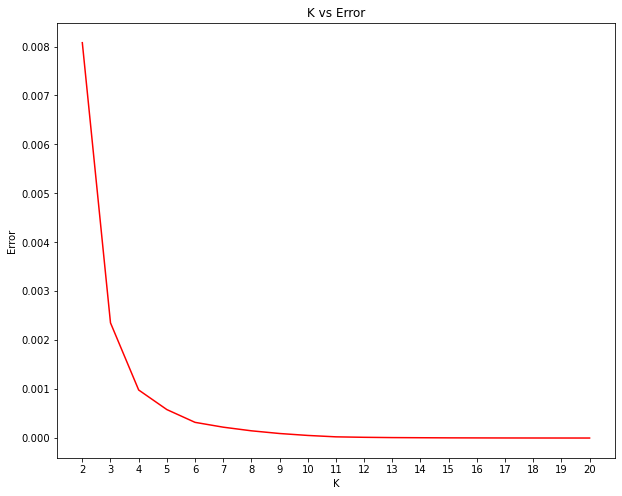

In [33]:
plt.figure(figsize=[10, 8])
sns.lineplot(x=range(2, 21), y=scores, color='r')
plt.title("K vs Error")
plt.xticks(range(2, 21))
plt.xlabel("K")
plt.ylabel("Error")

In [34]:
from yellowbrick.cluster import KElbowVisualizer

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


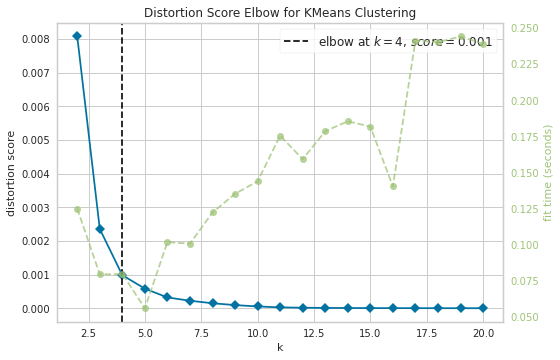

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [35]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,21))
visualizer.fit(X)# Fit the data to the visualizer
visualizer.show()

We can see that best value of k is 4

In [36]:
# set number of clusters
kclusters = 4

toronto_grouped_clustering = it.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 3, 0, 0, 2, 0, 0], dtype=int32)

In [37]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
toronto_merged = it.copy()

# add clustering labels
toronto_merged["Cluster Labels"] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(toronto_venues.set_index('Neighbourhood'), on='Neighbourhood')

toronto_merged.head()

,Neighbourhood,Italian Restaurant,Cluster Labels,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agincourt,0.0,0,43.7942,-79.262029,Panagio's Breakfast & Lunch,43.792370,-79.260203,Breakfast Spot
0,Agincourt,0.0,0,43.7942,-79.262029,El Pulgarcito,43.792648,-79.259208,Latin American Restaurant
0,Agincourt,0.0,0,43.7942,-79.262029,Twilight,43.791999,-79.258584,Lounge
0,Agincourt,0.0,0,43.7942,-79.262029,Mark's,43.791179,-79.259714,Clothing Store
0,Agincourt,0.0,0,43.7942,-79.262029,Commander Arena,43.794867,-79.267989,Skating Rink


In [38]:
# create map
map_clusters = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Neighbourhood Latitude'], toronto_merged['Neighbourhood Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Analysis of clusters

## Cluster 1

In [53]:
c1=toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[0,1] + list(range(5, toronto_merged.shape[1]))]]
c1

,Neighbourhood,Italian Restaurant,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agincourt,0.0,Panagio's Breakfast & Lunch,43.792370,-79.260203,Breakfast Spot
0,Agincourt,0.0,El Pulgarcito,43.792648,-79.259208,Latin American Restaurant
0,Agincourt,0.0,Twilight,43.791999,-79.258584,Lounge
0,Agincourt,0.0,Mark's,43.791179,-79.259714,Clothing Store
0,Agincourt,0.0,Commander Arena,43.794867,-79.267989,Skating Rink
...,...,...,...,...,...,...
94,Woodbine Heights,0.0,Stan Wadlow Park,43.697836,-79.314303,Park
94,Woodbine Heights,0.0,Luxy Nails,43.692856,-79.315849,Spa
95,York Mills West,0.0,Kitchen Food Fair,43.751298,-79.401393,Convenience Store
95,York Mills West,0.0,Tournament Park,43.751257,-79.399717,Park


## Cluster 2

In [54]:
c2=toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[0,1] + list(range(5, toronto_merged.shape[1]))]]
c2

,Neighbourhood,Italian Restaurant,Venue,Venue Latitude,Venue Longitude,Venue Category
13,Central Bay Street,0.049180,Jimmy's Coffee,43.658421,-79.385613,Coffee Shop
13,Central Bay Street,0.049180,Tim Hortons,43.658570,-79.385123,Coffee Shop
13,Central Bay Street,0.049180,Somethin' 2 Talk About,43.658395,-79.385338,Middle Eastern Restaurant
13,Central Bay Street,0.049180,Hailed Coffee,43.658833,-79.383684,Coffee Shop
13,Central Bay Street,0.049180,NEO COFFEE BAR,43.660130,-79.385830,Coffee Shop
...,...,...,...,...,...,...
73,"St. James Town, Cabbagetown",0.047619,Matt's No Frills,43.663515,-79.367166,Grocery Store
73,"St. James Town, Cabbagetown",0.047619,Cabbage Town Organics,43.664704,-79.368115,Gourmet Shop
73,"St. James Town, Cabbagetown",0.047619,Park Snacks,43.666979,-79.363115,Snack Place
73,"St. James Town, Cabbagetown",0.047619,D&W Fruits And Flowers,43.667817,-79.373064,Flower Shop


## Cluster 3

In [55]:
c3=toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[0,1] + list(range(5, toronto_merged.shape[1]))]]
c3

,Neighbourhood,Italian Restaurant,Venue,Venue Latitude,Venue Longitude,Venue Category
7,"Brockton, Parkdale Village, Exhibition Place",0.041667,Reebok Crossfit Liberty Village,43.637036,-79.424802,Gym
7,"Brockton, Parkdale Village, Exhibition Place",0.041667,Starbucks,43.639090,-79.427622,Coffee Shop
7,"Brockton, Parkdale Village, Exhibition Place",0.041667,Pharmacy,43.638090,-79.431810,Bar
7,"Brockton, Parkdale Village, Exhibition Place",0.041667,Louie Craft Coffee,43.639284,-79.425620,Coffee Shop
7,"Brockton, Parkdale Village, Exhibition Place",0.041667,Caffino,43.639021,-79.425289,Italian Restaurant
...,...,...,...,...,...,...
84,"University of Toronto, Harbord",0.032258,Charlie's Gallery,43.662810,-79.403822,Bar
84,"University of Toronto, Harbord",0.032258,DT Bistro,43.662375,-79.405734,Café
84,"University of Toronto, Harbord",0.032258,Smoke's Poutinerie/Weinerie,43.658259,-79.400136,Poutine Place
84,"University of Toronto, Harbord",0.032258,The Beer Store,43.665385,-79.403477,Beer Store


## Cluster 4

In [56]:
c4=toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[0,1] + list(range(5, toronto_merged.shape[1]))]]
c4

,Neighbourhood,Italian Restaurant,Venue,Venue Latitude,Venue Longitude,Venue Category
4,"Bedford Park, Lawrence Manor East",0.090909,Aroma Espresso Bar,43.735975,-79.420391,Café
4,"Bedford Park, Lawrence Manor East",0.090909,Darbar Persian Grill,43.735484,-79.420006,Restaurant
4,"Bedford Park, Lawrence Manor East",0.090909,Pheasant & Firkin,43.735173,-79.419702,Pub
4,"Bedford Park, Lawrence Manor East",0.090909,The Copper Chimney,43.736195,-79.420271,Indian Restaurant
4,"Bedford Park, Lawrence Manor East",0.090909,Francobollo,43.734557,-79.419549,Italian Restaurant
...,...,...,...,...,...,...
80,"The Danforth West, Riverdale",0.071429,LCBO,43.676816,-79.356047,Liquor Store
80,"The Danforth West, Riverdale",0.071429,IL FORNELLO on Danforth,43.678604,-79.346904,Italian Restaurant
80,"The Danforth West, Riverdale",0.071429,Factory Girl,43.676693,-79.356299,American Restaurant
80,"The Danforth West, Riverdale",0.071429,Kitchen Stuff Plus,43.678613,-79.346422,Furniture / Home Store


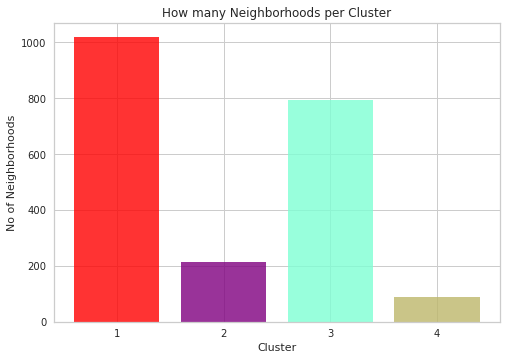

In [57]:
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
performance = toronto_merged['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('No of Neighborhoods')
plt.xlabel('Cluster')
plt.title('How many Neighborhoods per Cluster')

plt.show()

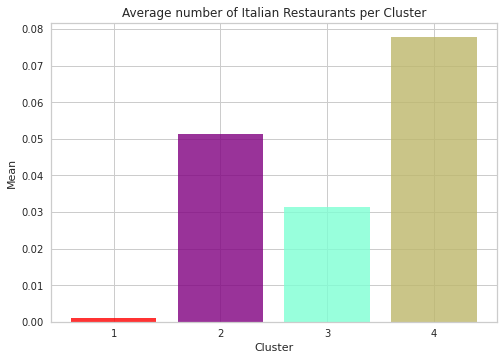

In [58]:
clusters_mean = [c1['Italian Restaurant'].mean(),c2['Italian Restaurant'].mean(),c3['Italian Restaurant'].mean(),
                 c4['Italian Restaurant'].mean()]
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
perf = clusters_mean
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('Mean')
plt.xlabel('Cluster')
plt.title('Average number of Italian Restaurants per Cluster')

plt.show()

## Conclusion

As seen from the above two plots there are more number of neighbourhoods in cluster 1 and Low number of Italian Restaurants (represented in Red).Neighbourhoods like Bedford park and the Danforth West have highest number of Italian restuarants(represented in Khaki). From the number of Neighbourhoods and Italian restaurants, neighbourhoods like Agincourt,Woodbine Heights,York Mills West are best places to start a new Italian restaurant as they have lowest number of pre existing Italian restaurants and hence less competition. Second best group of neighbourhoods are Brockton, Parkdale Village, Exhibition Place,University of Toronto and Harbord as they less number of Italian restaurants compared to other neighbourhoods.